In [1]:
import setuptools.dist
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pylab as plt
import pandas as pd
import os
import shutil
import numpy as np
import seaborn as sns

2024-06-13 09:36:19.389053: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 09:36:20.616462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Criar novo dataset binario sem actionable

In [3]:
#Função para visualização
def plot_image_counts2(folder_path):
    #Contadores pra plotar
    counts = {'cancer_type': 0, 'normal': 0}

    #Vai olhar os folders
    total_images = 0
    for class_name in counts.keys():
        class_path = os.path.join(folder_path, class_name)
        if os.path.exists(class_path):
            class_count = len(os.listdir(class_path))
            counts[class_name] = class_count
            total_images += class_count

    #Cálculo da porcentagem
    percentages = {class_name: count / total_images * 100 for class_name, count in counts.items()}

    #Plot dos gráficos
    plt.figure(figsize=(10, 6))
    plt.bar(percentages.keys(), percentages.values(), color=['blue',  'red'])
    plt.xlabel('Classe')
    plt.ylabel('Porcentagem')
    plt.title('Porcentagem de imagens em cada classe')
    plt.show()

    #Tabelinha
    df = pd.DataFrame({'Quantidade': counts.values(), 'Porcentagem': percentages.values()}, index=counts.keys())
    print("Tabela quantidade-porcentagem:")
    print(df)

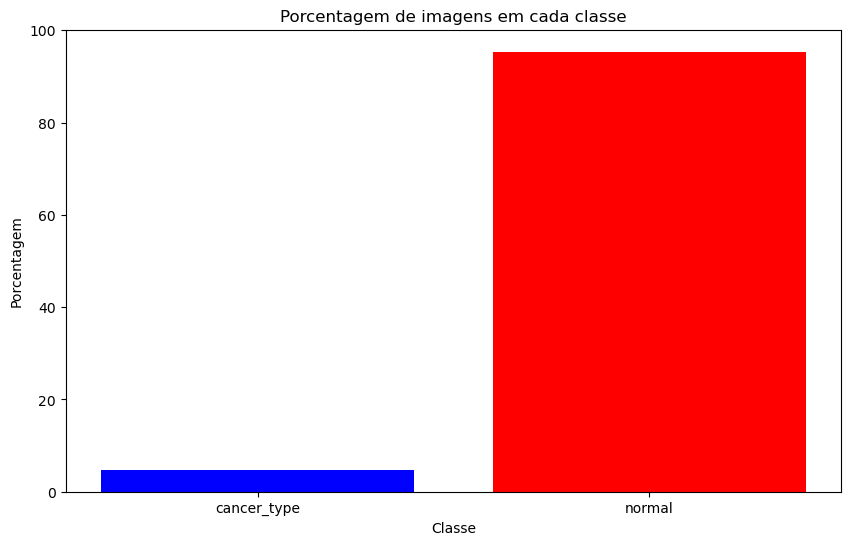

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type         200     4.641448
normal             4109    95.358552


In [8]:
#Train set binário sem data augmentation
folder_path = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/train'
plot_image_counts2(folder_path)

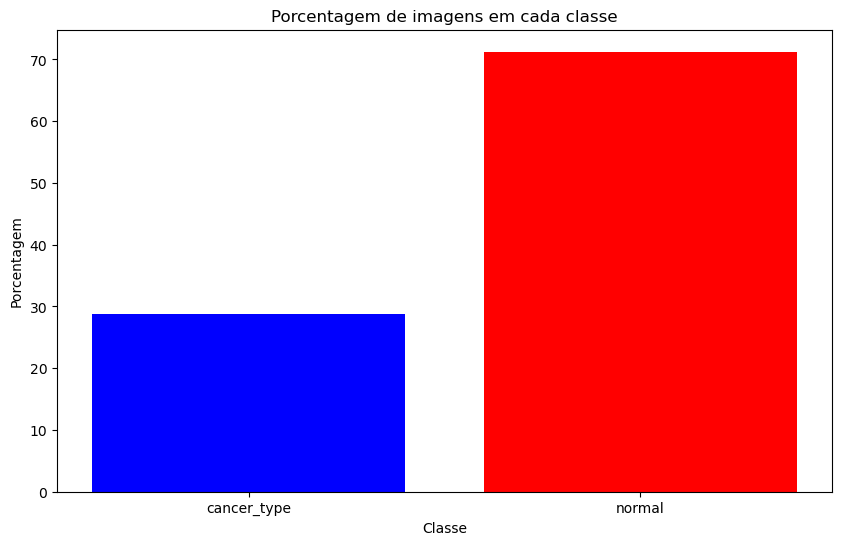

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type         121    28.741093
normal              300    71.258907


In [7]:
#Test set binário
folder_path = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/test'
plot_image_counts2(folder_path)

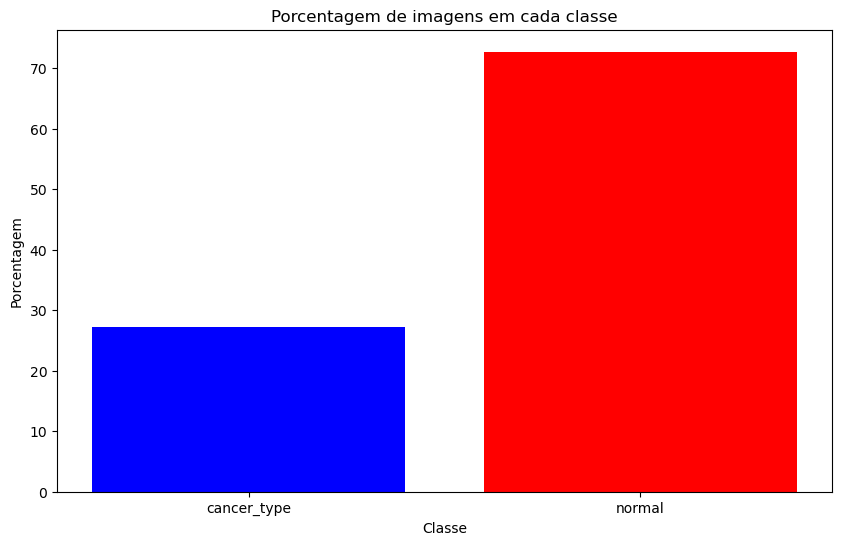

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type          75    27.272727
normal              200    72.727273


In [6]:
#Val set binário
folder_path = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/val'
plot_image_counts2(folder_path)

In [11]:
import os
import cv2
import numpy as np
import imgaug.augmenters as iaa

seq = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  #Ruido
    iaa.Fliplr(0.5),  #Horizontal flip com 50% de probabilidade
    iaa.Flipud(0.5),  #Vertical flip com 50% de probabilidade
    iaa.Affine(
        rotate=(-45, 45),  #Rotaciona de -45 ate 45 degrees
        scale=(0.8, 1.2),  #Rescale das imagens de 80-120% do tamanho original
    ),
    iaa.ElasticTransformation(alpha=50, sigma=5),  #Deformacao
    iaa.GammaContrast((0.5, 2.0)),  #Contraste
])

def augment_images(image_folder):
    images = os.listdir(image_folder)
    for image_name in images:
        image_path = os.path.join(image_folder, image_name)
        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            continue 
        
        #Aplica data augmentation
        augmented_images = seq(images=[image] * 6)  #Gena varias augmentations

        #Salva as imagens
        for idx, aug_image in enumerate(augmented_images):
            aug_image_path = os.path.join(image_folder, f"aug_{idx}_{image_name}")
            cv2.imwrite(aug_image_path, aug_image)

target_folder = r"/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final_augmented"

#Apenas nas classes minoritarias
train_folder = os.path.join(target_folder, "train")
for category in ["cancer_type"]:
    category_folder = os.path.join(train_folder, category)
    if os.path.exists(category_folder):
        augment_images(category_folder)

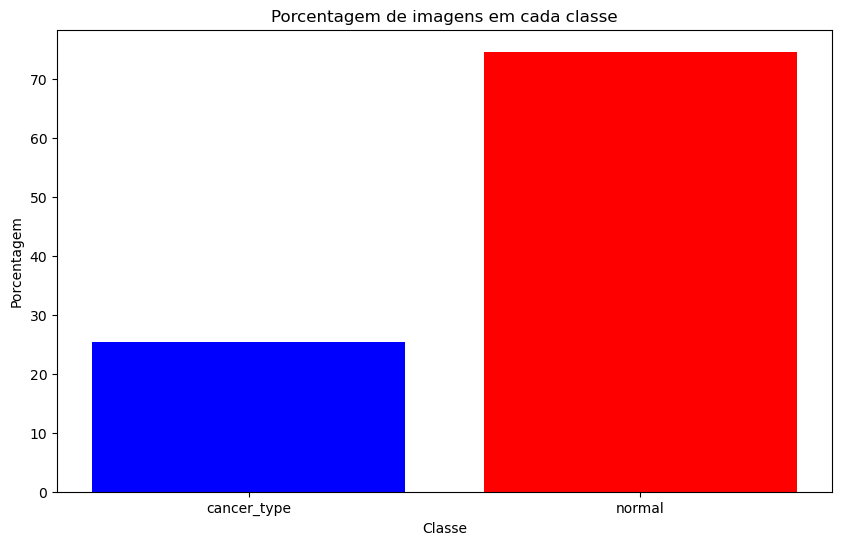

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type        1400    25.412961
normal             4109    74.587039


In [12]:
#Train set binário com data augmentation
folder_path = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final_augmented/train'
plot_image_counts2(folder_path)

In [2]:
#Diretórios
train_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final_augmented/train'
val_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final_augmented/val'
test_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final_augmented/test'

#Set das dimensões
img_width, img_height = 1890//4, 2457//4 
input_shape = (img_width, img_height, 3)

#Batch size
batch_size = 32

#CLasses
num_classes = 2

In [3]:
#Data generators
#train_datagen = ImageDataGenerator(rescale=1./255)
#val_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
val_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 5509 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 421 images belonging to 2 classes.


In [4]:
#Transfer learning com a densenet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 2 classes
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)

predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [5]:
#lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001, verbose=1)
adam = Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
#FAZER DEPOIS COM 0.0001

In [6]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose = 1, restore_best_weights=True)

In [7]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping])

Epoch 1/100


/home/breno/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-06-13 09:36:53.855857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-06-13 09:37:05.060206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-06-13 09:37:12.974945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1266s 7s/step - accuracy: 0.9192 - loss: 2.2750 - val_accuracy: 0.6982 - val_loss: 18.4768
Epoch 2/100


2024-06-13 09:57:55.104568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-06-13 09:57:58.488765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1239s 7s/step - accuracy: 0.9871 - loss: 0.2851 - val_accuracy: 0.7236 - val_loss: 34.1927
Epoch 3/100


2024-06-13 10:18:34.579124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-06-13 10:18:37.983205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1243s 7s/step - accuracy: 0.9910 - loss: 0.1241 - val_accuracy: 0.7309 - val_loss: 25.6150
Epoch 4/100


2024-06-13 10:39:55.900064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-06-13 10:39:59.005840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1282s 7s/step - accuracy: 0.9925 - loss: 0.1659 - val_accuracy: 0.7273 - val_loss: 55.1994
Epoch 5/100


2024-06-13 11:00:38.730031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-06-13 11:00:42.330540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1241s 7s/step - accuracy: 0.9966 - loss: 0.0314 - val_accuracy: 0.7200 - val_loss: 51.2548
Epoch 6/100


2024-06-13 11:21:20.613230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 11:21:22.220478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1240s 7s/step - accuracy: 0.9964 - loss: 0.0667 - val_accuracy: 0.7273 - val_loss: 49.0837
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1238s 7s/step - accuracy: 0.9967 - loss: 0.0953 - val_accuracy: 0.7273 - val_loss: 70.5370
Epoch 8/100


2024-06-13 12:02:38.025720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 12:02:39.650292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1240s 7s/step - accuracy: 0.9980 - loss: 0.0563 - val_accuracy: 0.7273 - val_loss: 61.7755
Epoch 9/100


2024-06-13 12:23:17.912803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 12:23:19.490161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1239s 7s/step - accuracy: 0.9983 - loss: 0.0395 - val_accuracy: 0.7273 - val_loss: 63.5170
Epoch 10/100


2024-06-13 12:43:56.890929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 12:43:58.488842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1239s 7s/step - accuracy: 0.9956 - loss: 0.1188 - val_accuracy: 0.7273 - val_loss: 69.8768
Epoch 11/100


2024-06-13 13:04:35.946091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 13:04:37.518460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1239s 7s/step - accuracy: 0.9973 - loss: 0.0572 - val_accuracy: 0.7200 - val_loss: 45.0266
Epoch 12/100


2024-06-13 13:25:14.824488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 13:25:16.489856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1239s 7s/step - accuracy: 0.9910 - loss: 0.3838 - val_accuracy: 0.7273 - val_loss: 89.4392
Epoch 13/100


2024-06-13 13:45:54.593558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 13:45:56.185034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1241s 7s/step - accuracy: 0.9988 - loss: 0.0792 - val_accuracy: 0.7236 - val_loss: 68.0325
Epoch 14/100


2024-06-13 14:06:34.980364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 14:06:36.502822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1239s 7s/step - accuracy: 0.9988 - loss: 0.0089 - val_accuracy: 0.7236 - val_loss: 70.9655
Epoch 15/100


2024-06-13 14:27:13.589462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 14:27:15.095916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1239s 7s/step - accuracy: 0.9985 - loss: 0.0275 - val_accuracy: 0.7236 - val_loss: 60.8446
Epoch 16/100


2024-06-13 14:47:52.157529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 14:47:53.729293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1238s 7s/step - accuracy: 0.9979 - loss: 0.0489 - val_accuracy: 0.7273 - val_loss: 149.6241
Epoch 17/100


2024-06-13 15:08:30.302270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 15:08:31.992577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1239s 7s/step - accuracy: 0.9952 - loss: 0.2202 - val_accuracy: 0.7273 - val_loss: 115.0959
Epoch 18/100


2024-06-13 15:29:09.767185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 15:29:11.444260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1238s 7s/step - accuracy: 0.9994 - loss: 0.0166 - val_accuracy: 0.7273 - val_loss: 115.8585
Epoch 19/100


2024-06-13 15:49:47.465976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 15:49:49.119665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1238s 7s/step - accuracy: 0.9989 - loss: 0.0598 - val_accuracy: 0.7345 - val_loss: 86.3234
Epoch 20/100


2024-06-13 16:10:25.488916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 16:10:27.127319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1239s 7s/step - accuracy: 0.9981 - loss: 0.0980 - val_accuracy: 0.7273 - val_loss: 101.7855
Epoch 21/100


2024-06-13 16:31:04.039649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 16:31:05.611653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1240s 7s/step - accuracy: 0.9979 - loss: 0.0900 - val_accuracy: 0.7273 - val_loss: 133.3096
Epoch 22/100


2024-06-13 16:51:43.651499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 16:51:45.309203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1240s 7s/step - accuracy: 0.9988 - loss: 0.0372 - val_accuracy: 0.7273 - val_loss: 126.1952
Epoch 23/100


2024-06-13 17:12:23.266796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 17:12:24.774374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1240s 7s/step - accuracy: 0.9993 - loss: 0.0269 - val_accuracy: 0.7200 - val_loss: 90.1740
Epoch 24/100


2024-06-13 17:33:04.159263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 17:33:05.893344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1239s 7s/step - accuracy: 0.9990 - loss: 0.0238 - val_accuracy: 0.7236 - val_loss: 108.7424
Epoch 25/100


2024-06-13 17:53:41.980103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 17:53:43.459651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1239s 7s/step - accuracy: 0.9990 - loss: 0.0262 - val_accuracy: 0.7236 - val_loss: 122.8755
Epoch 26/100


2024-06-13 18:14:21.822515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-13 18:14:23.523588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 1239s 7s/step - accuracy: 0.9984 - loss: 0.0290 - val_accuracy: 0.7273 - val_loss: 155.8392
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 1.


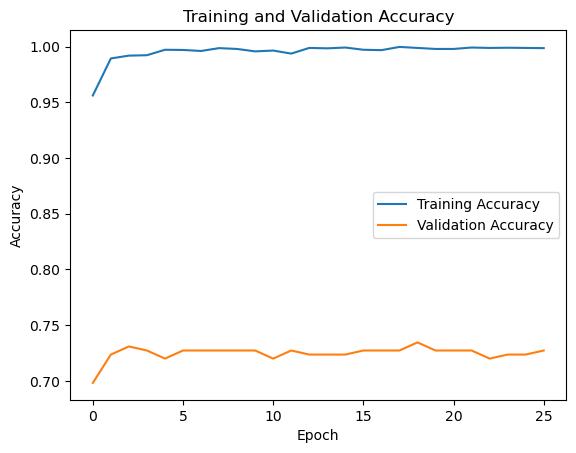

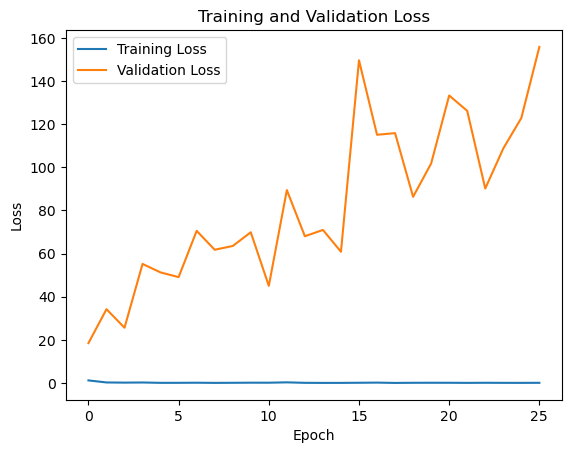

In [8]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 91s 6s/step - accuracy: 0.9253 - loss: 2.1425
Test Accuracy: 92.64%
Test Loss: 2.2302


In [10]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

14/14 ━━━━━━━━━━━━━━━━━━━━ 93s 6s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [11]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

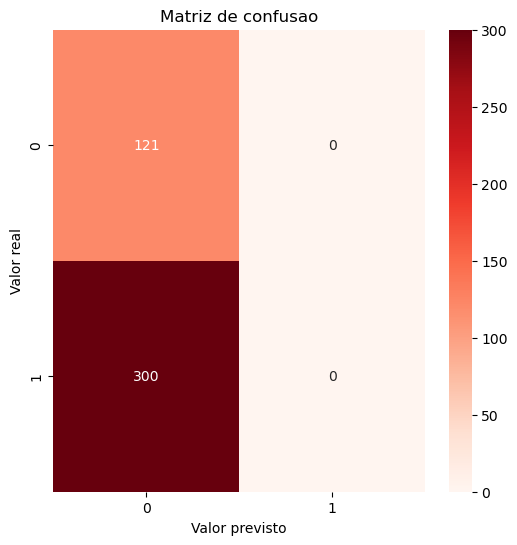

In [12]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 472, 614,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 478, 620,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 236, 307,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 236, 307,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 236, 307,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 238, 309,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 118, 154,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 118, 154,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 118, 154,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 118, 154,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 118, 154,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 118, 154,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 118, 154,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 118, 154,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 118, 154,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 118, 154,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 118, 154,  │      1,024 │ conv2_block1_3_c

 Total params: 25,430,917 (97.01 MB)

 Trainable params: 614,401 (2.34 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 1,228,804 (4.69 MB)